In [44]:
# load libraries and scripts
using HDF5
using Trapz
#using Statistics
include("../scripts/plotting.jl")
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/disturbances.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")

vectorize (generic function with 1 method)

In [45]:
#load borders
border, scale_factor = import_border("../data/borders/border.json");

#data, ~ = import_json_numerics("../data/test/triangle.json");
#border = data["border"]

In [53]:
# create the lattice grid
include("../scripts/get_grid.jl")
dx = 0.002
@time begin
Nx, Ny, xrange, yrange, isinside, isborder, n, isgrid = get_grid(border, Float64(dx));
end

#@time begin
#Nx, Ny, xrange, yrange, isinside, isborder, n, isgrid = get_grid_fast(border, Float64(dx));
#end

  0.133105 seconds (765.93 k allocations: 137.289 MiB, 8.45% gc time)


In [54]:
#p = [(xrange[j],yrange[i]) for i in 1:Ny for j in 1:Nx]
p = [(yrange[i], xrange[j]) for i in 1:Ny for j in 1:Nx]
x = repeat(reshape(xrange,1,Nx), Ny, 1)
y = repeat(reshape(yrange,Ny,1), 1, Nx);
#x = repeat(xrange,1,1:Ny)
#println(size(y))
#println(size(x))
println(size(p))
println(size(vec(isinside)))
#scatter([p[i][1] for i in 1:length(p)], [p[i][2]  for i in 1:length(p)])

(189375,)
(189375,)


In [55]:
m = 30 * ones(Ny, Nx)
d = 0.6 * m
bx = 10 * ones(Ny, Nx)
by = 10 * ones(Ny, Nx)
p = zeros(Ny, Nx)
m[.!isgrid] .= 0
d[.!isgrid] .= 0
p[.!isgrid] .= 0;
sum(bx)*dx*dx

7.575

In [56]:
@time begin
isinsideflat, pflat, minvflat, gammaflat, xi = vectorize(isinside, isborder, n, bx, by, p, m, d);
end

#@time begin
#isinsideflat, pflat, minvflat, gammaflat, xi2 = vectorize(isinside, isborder, n, bx, by, p, m, d);
#end
#sum(abs.(Array{Float64,2}(xi)-Array{Float64,2}(xi2)))

  0.035193 seconds (118 allocations: 53.751 MiB, 24.67% gc time)


In [57]:
isgridflat = vec(isinside .| isborder);

Synchronized frequency: -1.4186650928941997
Synchronized frequency: -1.4186650928941893


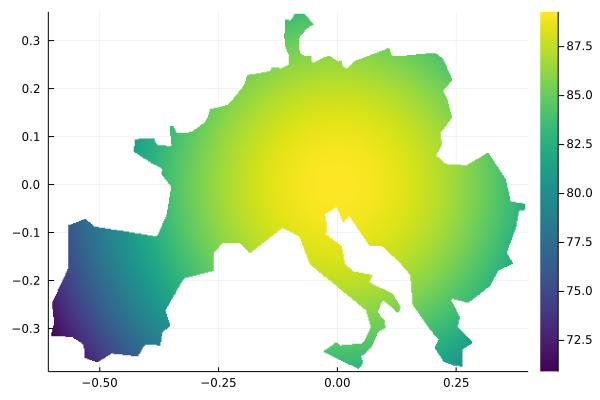

In [58]:
# define a disturbance
dP = -9.0
# dP = 0.0
sigma = 100.0 / scale_factor
location = [-1500.0, -900.0] / scale_factor
#sigma = 0.1
#location = [00.0, 00.0] / scale_factor
dp = local_disturbance(isgrid, xrange, yrange, location, dP, sigma)
dpflat = vec(dp)
println("Synchronized frequency: ", trapz((yrange, xrange), p .+ dp) / trapz((yrange, xrange), d))
println("Synchronized frequency: ", sum(p .+ dp) / sum(d))
#hm_plot(isinside, xrange, yrange, dp)

sigma = 1.0
location = [00.0, 00.0] / scale_factor
dbx = local_disturbance(isgrid, xrange, yrange, location, 30.0, sigma)
location = [250.0, 00.0] / scale_factor
dby = local_disturbance(isgrid, xrange, yrange, location, 30.0, sigma)
bx .+= dbx
by .+= dby
hm_plot(isinside, xrange, yrange, dbx)

In [59]:
th0 = zeros(Ny * Nx)

ts, ~, omegas = perform_dyn_sim(isgridflat, xi, pflat[isgridflat]+dpflat[isgridflat],
    minvflat, gammaflat, th0, interval = 1000, Ndt = Int64(30000), dt = 0.001, method = "crank-nicolson")
o_ref = sum(p .+ dp) / sum(d)
println("|avg_omega - omega_ref| / |omege_ref|: ", abs(sum(omegas[:,end])/sum(isgridflat)- o_ref) / abs(o_ref))

Total time: 30.0
NIter: 1000 Avg. Omega: -0.6400851959484853
NIter: 2000 Avg. Omega: -0.991371393442518
NIter: 3000 Avg. Omega: -1.184161342804761
NIter: 4000 Avg. Omega: -1.2899667084525401
NIter: 5000 Avg. Omega: -1.3480339232402845
NIter: 6000 Avg. Omega: -1.3799018858177838
NIter: 7000 Avg. Omega: -1.3973913941830534
NIter: 8000 Avg. Omega: -1.4069898397100629
NIter: 9000 Avg. Omega: -1.4122575782077407
NIter: 10000 Avg. Omega: -1.4151485743390624
NIter: 11000 Avg. Omega: -1.4167351866274567
NIter: 12000 Avg. Omega: -1.417605937897635
NIter: 13000 Avg. Omega: -1.4180838163182607
NIter: 14000 Avg. Omega: -1.4183460815513904
NIter: 15000 Avg. Omega: -1.418490015760465
NIter: 16000 Avg. Omega: -1.4185690085277989
NIter: 17000 Avg. Omega: -1.4186123606770622
NIter: 18000 Avg. Omega: -1.4186361528405491
NIter: 19000 Avg. Omega: -1.4186492102564334
NIter: 20000 Avg. Omega: -1.4186563763180051
NIter: 21000 Avg. Omega: -1.418660309135937
NIter: 22000 Avg. Omega: -1.4186624675120878
NIter: 

In [ ]:
# backward Euler
coord = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400]/scale_factor
time_plot(ts_be, omegas_be, coord, tstart = 0.0, tend = 50.0, borders = [border])

In [ ]:
# Crank-Nicolson
coord = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400]
time_plot(ts_cn, omegas_cn, coord, tstart = 0.0, tend = 10.0, borders = [border])

In [ ]:
# "Standard vec"
coord = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400]
time_plot(ts_v, omegas_v, coord, tstart = 0.0, tend = 10.0, borders = [border])

In [ ]:
heatmap(omegas_be[:,:,10],fill=true)


In [ ]:
N = sum(isgridflat)
dt = 0.001
th0 = zeros(Ny * Nx)

I = sparse(1:N, 1:N, ones(N))
A = [I -dt / 2 * I;
    - dt / 2 / dx^2 * sparse(1:N, 1:N, minvflat) * xi (I + dt/2 * sparse(1:N, 1:N, gammaflat))]
B = [I dt / 2 * I;
    dt / 2 / dx^2 * sparse(1:N, 1:N, minvflat) * xi (I - dt/2 * sparse(1:N, 1:N, gammaflat))]
C = [zeros(N); dt * sparse(1:N, 1:N, minvflat) * dpflat[isgridflat]]
x = [zeros(N); th0[isgridflat]]
x2 = [zeros(N); th0[isgridflat]]
println(size(x))
println(size(A))
println(size(B))
println(size(C))
@time begin
    x1 = A \ (B * x + C)
end
x = [zeros(N); th0[isgridflat]]
@time begin
    gmres!(x2, A, (B * x + C))
end

println(sum(abs.(A * x1 - (B * x + C))))
println(sum(abs.(A * x2 - (B * x + C))))